<a href="https://colab.research.google.com/github/krikorantranik/Work/blob/main/GoogleTrendsMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project is a very ambitious attempt to predict the gas prices based on three algorithms: NLP (word2vec) to find words related to 'Oil', time series decomposition after Fourier analysis (to predict each time effect separately), and neural networks with Keras to predict, using the frequency of word searches in Google, the random variation of the oil price.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import MSTL
!pip install klib
import klib
from scipy import spatial
import gensim.downloader as api
from statsmodels.tsa.seasonal import MSTL
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from datetime import timedelta
import tensorflow as tf
import math
import nltk
nltk.download('wordnet')
!pip install pmdarima
from pmdarima import auto_arima


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.1 MB/s eta 0:00:00


Word2Vec is the right choice for the NLP portion of the analysis because: 1) It is trained to be used for similarities-distances, unlike BERT, for example, which is usually trained for different downstream tasks, like masking. 2) It generates word embeddings, which is what we are trying to obtain and compare.

I am using here a library called gensim downloader, which has a set of pretrained Word2Vec models with huge datasets, so that we don't have to suffer through that. In this case, it is fine because we are going to use this over Google data, which is supposed to be clean.

I am downloading two big models.

In [ ]:

model1 = api.load("glove-wiki-gigaword-200")
model2 = api.load("glove-twitter-100")


[==================================================] 100.0% 252.1/252.1MB downloaded
[==================================================] 100.0% 387.1/387.1MB downloaded


I am defining a function to get the most similar words from both models, and average them out. See the results of a test

In [ ]:
def close_words(wrd):
 tbl1 = pd.DataFrame(model1.most_similar(wrd, topn=10), columns=['word','siml']).set_index('word')
 tbl2 = pd.DataFrame(model2.most_similar(wrd, topn=10), columns=['word','siml']).set_index('word')
 tbl = pd.concat((tbl1, tbl2), axis=1).mean(axis=1)
 tbl = pd.DataFrame(tbl).sort_values(0, ascending=False)
 return tbl

dfs = []


Here I do a search on several keywords I think are related to oil or oil prices. First I start with the word oil, then I look for other words that come from the list, following a "chain". The step after this one "saves" the search results to a list of dataframes.

In [ ]:
search = 'barrels'
wordsim = close_words(search)

lemmatizer = WordNetLemmatizer()
wordsim['Lemma'] = wordsim.index
wordsim['Lemma'] = wordsim['Lemma'].apply(lambda x: lemmatizer.lemmatize(x))
wordsim

,0,Lemma
word,,
crude,0.727617,crude
bpd,0.709313,bpd
barrel,0.634681,barrel
"900,000",0.610963,"900,000"
shotguns,0.598264,shotgun
tons,0.595889,ton
bourbon,0.595722,bourbon
output,0.594559,output
oil,0.593525,oil


In [ ]:
dfs.append(wordsim)

Now I save it all to a list, which I am going to use to search in Google Trends using a third party API called Google Trends Scraper (https://apify.com/emastra/google-trends-scraper)

In [ ]:
finaldf = pd.concat(dfs, ignore_index=True).groupby('Lemma').mean()
finaldf.to_csv("finaldf.csv")

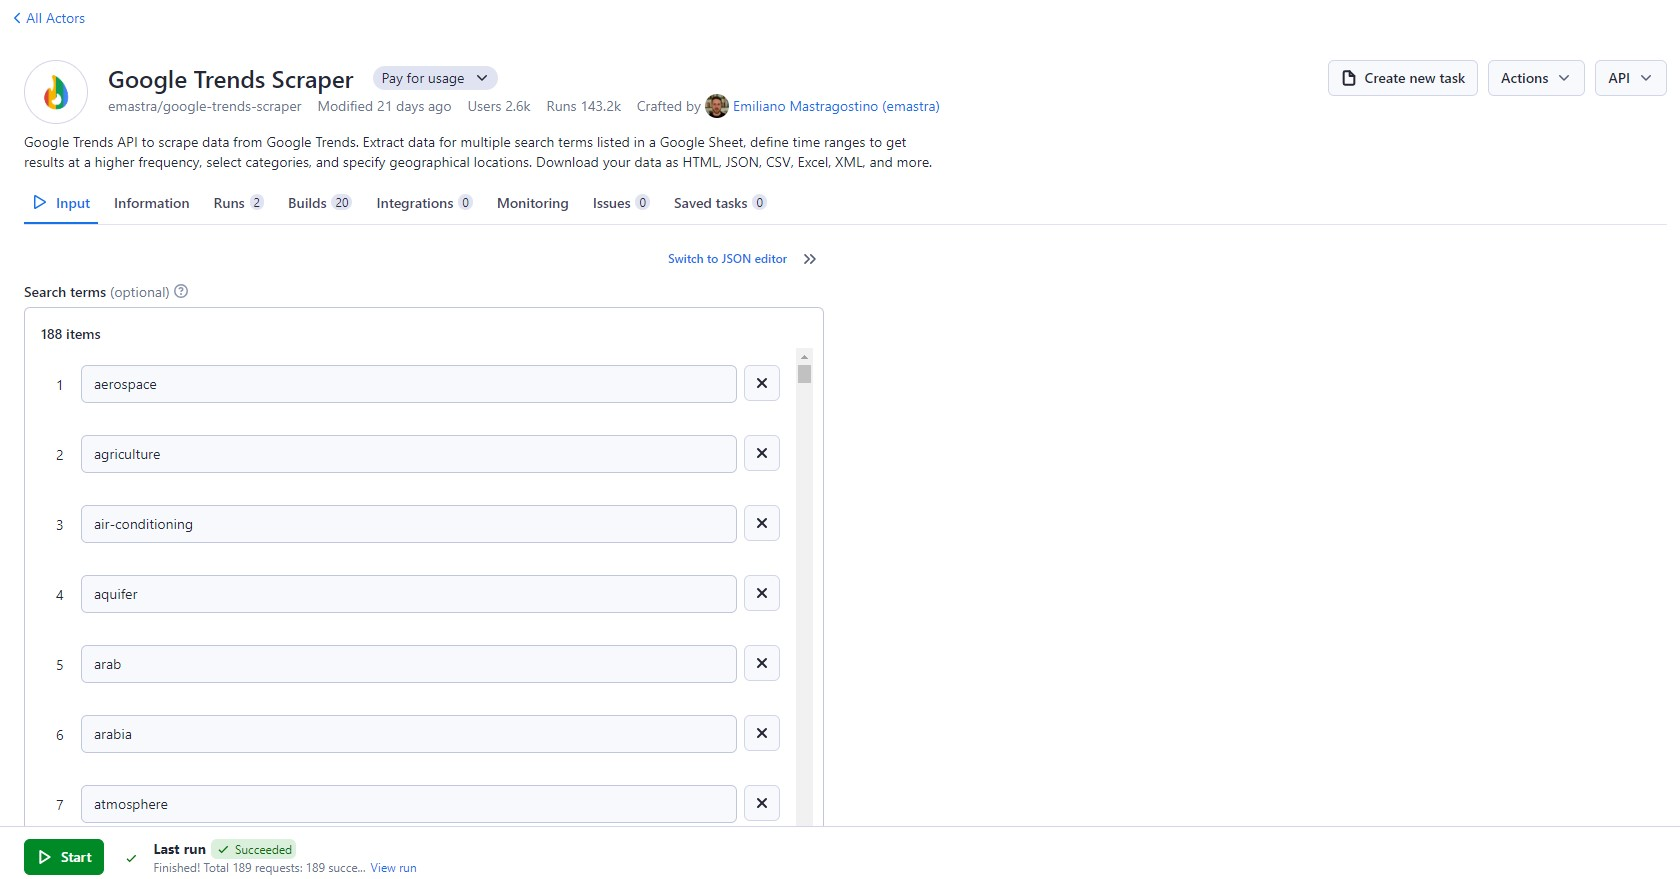

Part 2:

Once the scraper is done, I save the results and import them. They are in a transposed format, so I account for that next and five the time series their format, same with the numbers

In [ ]:
workdf = pd.read_csv("dataset_google-trends-scraper_2023-10-17_07-39-06-381.csv")
workdf = workdf.T
df2 = workdf.iloc[[-1]]
workdf = workdf[:-1]
workdf.columns = list(df2.values[0])
workdf['Timestamp'] = workdf.index
workdf['Timestamp'] = pd.to_datetime(workdf['Timestamp'], format='%b %d, %Y')
workdf = workdf.sort_values('Timestamp')
workdf = workdf.set_index('Timestamp')
workdf = workdf.apply(pd.to_numeric, errors='coerce', axis=1)
workdf

,arabia,air-conditioning,arab,atmosphere,aviation,atomic,bahrain,banking,barrel,biofuel,...,refinery,aerospace,uae,truck,suv,war,unrest,groundwater,gulf,utility
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-10-21,8,31,55,60,85,19,30,88,72,51,...,42,66,42,58,67,40,7,65,49,83
2018-10-28,6,39,55,63,90,20,30,100,79,56,...,43,69,42,62,67,39,8,65,56,91
2018-11-04,6,32,49,55,82,19,30,86,66,64,...,37,65,39,61,65,45,7,59,45,92
2018-11-11,6,34,50,64,83,19,32,93,73,54,...,44,71,39,63,69,45,9,63,48,83
2018-11-18,6,25,48,53,77,16,29,83,84,50,...,37,57,45,59,66,38,8,55,42,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-10,9,49,51,83,88,27,36,52,48,100,...,41,85,61,58,78,34,7,57,44,86
2023-09-17,10,43,55,79,91,25,40,51,47,66,...,41,83,63,60,78,38,9,57,44,87
2023-09-24,10,44,53,75,90,25,37,56,50,59,...,37,80,63,57,72,36,9,62,41,89


After much iteration, I found that the predictors also have some seasonality in them, so I decompose them using a schedule of 52 and 104 weeks (one and two years)

In [ ]:
a = []
for col in workdf.columns:
 sea = MSTL(workdf[col], periods=(52, 104)).fit()
 res = pd.DataFrame(sea.resid)
 res.columns = [col]
 a.append(res)

xres = pd.concat(a, axis=1)
xres

,arabia,air-conditioning,arab,atmosphere,aviation,atomic,bahrain,banking,barrel,biofuel,...,refinery,aerospace,uae,truck,suv,war,unrest,groundwater,gulf,utility
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-10-21,-0.330499,0.604723,-0.711202,-0.598436,-2.731577,-0.931098,1.257727,0.655854,1.902172,0.275871,...,0.303491,-2.465895,5.780474,-1.301850,-1.109410,1.250140,-1.423068,0.658969,-0.868316,-1.113794
2018-10-28,-0.481795,2.734440,0.047960,0.310680,-0.024611,-0.783317,0.948780,1.728312,2.819447,1.483197,...,-0.771127,4.332443,-0.880070,-0.231644,0.261295,1.240100,-5.524777,0.198041,-0.102704,0.102789
2018-11-04,-0.177792,-0.294047,-0.102996,0.159584,2.532669,-0.483684,1.854599,0.370486,2.225104,4.666172,...,-0.176217,2.186717,0.803009,1.293980,1.936709,2.442494,-15.244209,2.623653,0.057565,2.683083
2018-11-11,-0.632351,-0.895578,-0.407717,1.676017,-1.134711,0.120042,1.088970,1.589684,1.321502,3.293487,...,0.874353,0.645085,-0.397407,0.389966,1.637852,-1.062094,-0.818185,0.189251,0.368441,0.254250
2018-11-18,0.278555,-4.987020,-0.407916,0.463205,-1.611938,-0.489912,1.236553,1.143898,0.263799,1.467589,...,-1.412086,0.472478,5.673089,0.404718,-0.479705,-2.741562,0.396400,-0.118083,0.073762,0.862260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-10,0.741927,1.275390,-1.734964,0.535306,-1.297249,0.340192,0.293424,-0.994948,0.246739,8.077910,...,0.840155,0.791406,-1.218987,-0.772352,1.828134,-0.539027,0.525010,-0.155463,-0.733190,-0.854110
2023-09-17,0.147356,1.577602,-0.820589,-1.283480,0.541336,-0.108586,1.055370,-1.137541,-1.419929,2.327587,...,-2.185963,-0.101669,0.298315,0.291093,0.604832,0.523190,0.667005,1.226761,0.488243,-2.363483
2023-09-24,0.159071,-0.704391,-0.514733,-0.824099,0.407160,-0.103025,1.210704,-0.824479,-2.329986,1.725365,...,-1.270714,1.433866,1.367192,-0.012060,1.660539,3.557171,1.565698,1.997020,0.346123,0.682640


Next, I import the gas prices from government data, apply format to them as well

In [ ]:
ydf = pd.read_csv("GASREGW.csv")
from datetime import timedelta
ydf['DATE'] = pd.to_datetime(ydf['DATE'], format='%Y-%m-%d')  - timedelta(days=1)
ydf = ydf.sort_values('DATE')
ydf = ydf.set_index('DATE')
ydf = ydf.apply(pd.to_numeric, errors='coerce', axis=1)
ydf

,GASREGW
DATE,
2018-10-14,2.879
2018-10-21,2.841
2018-10-28,2.811
2018-11-04,2.753
2018-11-11,2.686
...,...
2023-09-17,3.878
2023-09-24,3.837
2023-10-01,3.798


Now, I want to explore more about the seasonality of oil prices. In order to do that, I do a Fourier transform on the series to find the period (in weeks) of the possible components. I then extract those components with higher amplitude and use those as the input for the seasonal decomposition.

In [ ]:
from scipy.fft import fft, fftfreq
import numpy as np
yf = fft(ydf['GASREGW'].values)
N = len(ydf)
xf = 1/(fftfreq(N, d=1.0))
nyf = np.abs(yf)
four = pd.DataFrame({'Period':xf, 'Amp':nyf})
four = four[(four['Period']>0) & (four['Period']<=200)]
four = four.sort_values(['Period'], ascending=True)
four['Period'] = four['Period'].apply(lambda x: math.floor(x))
four = four.groupby('Period').max().reset_index(drop=False)
four = four.sort_values('Amp', ascending=False).head(5)
four

<ipython-input-33-440085b02262>:5: RuntimeWarning: divide by zero encountered in divide
  xf = 1/(fftfreq(N, d=1.0))


,Period,Amp
26,65,35.751044
25,52,30.918006
28,131,27.718713
22,32,20.674774
23,37,12.007991


This is the time-series decomposition. Note that I replaced 131 weeks with 104 weeks, since I can't go further with the data I have.

The results are very nice, I believe. I see a clear trend and seasonal components.

What I am going to predict is the residual.

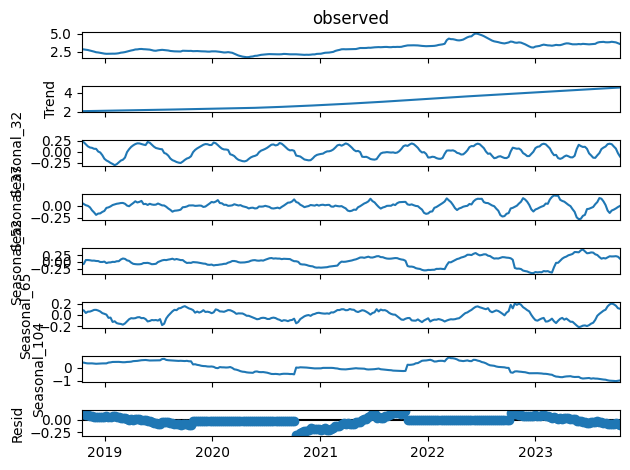

In [ ]:
seas = MSTL(ydf['GASREGW'], periods=(32, 37, 52, 65, 104)).fit()
seas.plot()
plt.tight_layout()
plt.show()

In [ ]:
ydf['seasonal_32'] = seas.seasonal['seasonal_32']
ydf['seasonal_37'] = seas.seasonal['seasonal_37']
ydf['seasonal_52'] = seas.seasonal['seasonal_52']
ydf['seasonal_65'] = seas.seasonal['seasonal_65']
ydf['seasonal_104'] = seas.seasonal['seasonal_104']
ydf['Trend'] = seas.trend
ydf['Resid'] = seas.resid
ydf['Diff'] = ydf['Resid'].diff(-1)
ydf

,GASREGW,seasonal_32,seasonal_37,seasonal_52,seasonal_65,seasonal_104,Trend,Resid,Diff
DATE,,,,,,,,,
2018-10-14,2.879,0.238169,0.062054,-0.082581,0.091637,0.374215,2.082253,0.113252,0.004813
2018-10-21,2.841,0.221195,0.036862,-0.071466,0.079177,0.380888,2.085904,0.108440,0.017041
2018-10-28,2.811,0.174373,0.010197,0.071157,0.033679,0.340629,2.089565,0.091399,0.005704
2018-11-04,2.753,0.127687,-0.002368,0.071777,0.057184,0.319787,2.093238,0.085695,0.010659
2018-11-11,2.686,0.101349,-0.033738,0.063600,0.058681,0.324151,2.096923,0.075036,0.004828
...,...,...,...,...,...,...,...,...,...
2023-09-17,3.878,0.175896,-0.101218,0.201309,0.202861,-1.007587,4.483772,-0.077033,-0.002312
2023-09-24,3.837,0.124219,-0.082241,0.204170,0.188452,-1.018873,4.495993,-0.074721,-0.002727
2023-10-01,3.798,0.076408,-0.057333,0.211849,0.164004,-1.033141,4.508206,-0.071994,0.010145


Scaling the input data

In [ ]:
def properscaler(simio):
 scaler = StandardScaler()
 resultsWordstrans = scaler.fit_transform(simio)
 resultsWordstrans = pd.DataFrame(resultsWordstrans)
 resultsWordstrans.index = simio.index
 resultsWordstrans.columns = simio.columns
 return resultsWordstrans

xresidualsS = properscaler(xres)
xresidualsS

,arabia,air-conditioning,arab,atmosphere,aviation,atomic,bahrain,banking,barrel,biofuel,...,refinery,aerospace,uae,truck,suv,war,unrest,groundwater,gulf,utility
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-10-21,-0.070350,0.165959,-0.408323,-0.314853,-1.083271,-0.366781,0.499878,0.587424,1.126400,0.226270,...,0.318641,-0.845790,2.133580,-1.549842,-0.895158,0.686088,-0.421696,0.613868,-0.401372,-0.694890
2018-10-28,-0.131793,0.992183,0.052995,0.250077,0.392392,-0.293084,0.390117,1.510660,1.697744,0.763678,...,-0.232448,2.466582,-0.423657,-0.372133,0.005122,0.681242,-1.526335,0.332409,-0.024471,0.171016
2018-11-04,-0.008334,-0.182719,-0.038735,0.156185,1.786455,-0.143659,0.711931,0.341763,1.327545,2.180489,...,0.072635,1.421114,0.222541,1.306740,1.105534,1.261611,-4.143893,1.813575,0.054427,2.007549
2018-11-11,-0.192936,-0.416082,-0.223905,1.098507,-0.212763,0.157413,0.439923,1.391321,0.764717,1.569477,...,0.611392,0.669981,-0.238344,0.311918,0.909245,-0.429977,-0.258794,0.327042,0.207467,0.278819
2018-11-18,0.176994,-2.003357,-0.224026,0.344857,-0.472916,-0.146766,0.492355,1.007562,0.105904,0.756730,...,-0.561147,0.585881,2.092351,0.328152,-0.481567,-1.240620,0.068309,0.139372,0.062400,0.711572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-10,0.365176,0.426144,-1.030429,0.389662,-0.301368,0.267200,0.157286,-0.833684,0.095277,3.699129,...,0.593855,0.741273,-0.553780,-0.967155,1.034223,-0.177504,0.102945,0.116547,-0.334851,-0.510059
2023-09-17,0.123713,0.543388,-0.474794,-0.740544,0.700909,0.043398,0.427986,-0.956437,-0.942842,1.139534,...,-0.958008,0.306138,0.028770,0.203112,0.230757,0.335205,0.141186,0.960582,0.266444,-1.584361
2023-09-24,0.128470,-0.341911,-0.288935,-0.455082,0.627765,0.046172,0.483172,-0.686934,-1.509691,0.871472,...,-0.488648,1.054300,0.439152,-0.130491,0.924146,1.799642,0.383215,1.430930,0.196480,0.583727


What I am going to predict, after exploring other options, is the differential of the residual, so I calculate that and use it as response variable.

In [ ]:
DF = pd.merge(xresidualsS, ydf, left_index=True, right_index=True)
DF['Diff'] = DF['Diff'].apply(lambda x: math.tanh(x))
DF.index = workdf.index
DF = DF.dropna()
DFf = DF.drop(columns=['GASREGW','seasonal_32','seasonal_37','seasonal_52','seasonal_65','seasonal_104','Trend','Resid'])
DFf

,arabia,air-conditioning,arab,atmosphere,aviation,atomic,bahrain,banking,barrel,biofuel,...,aerospace,uae,truck,suv,war,unrest,groundwater,gulf,utility,Diff
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-10-21,-0.070350,0.165959,-0.408323,-0.314853,-1.083271,-0.366781,0.499878,0.587424,1.126400,0.226270,...,-0.845790,2.133580,-1.549842,-0.895158,0.686088,-0.421696,0.613868,-0.401372,-0.694890,0.017040
2018-10-28,-0.131793,0.992183,0.052995,0.250077,0.392392,-0.293084,0.390117,1.510660,1.697744,0.763678,...,2.466582,-0.423657,-0.372133,0.005122,0.681242,-1.526335,0.332409,-0.024471,0.171016,0.005704
2018-11-04,-0.008334,-0.182719,-0.038735,0.156185,1.786455,-0.143659,0.711931,0.341763,1.327545,2.180489,...,1.421114,0.222541,1.306740,1.105534,1.261611,-4.143893,1.813575,0.054427,2.007549,0.010659
2018-11-11,-0.192936,-0.416082,-0.223905,1.098507,-0.212763,0.157413,0.439923,1.391321,0.764717,1.569477,...,0.669981,-0.238344,0.311918,0.909245,-0.429977,-0.258794,0.327042,0.207467,0.278819,0.004828
2018-11-18,0.176994,-2.003357,-0.224026,0.344857,-0.472916,-0.146766,0.492355,1.007562,0.105904,0.756730,...,0.585881,2.092351,0.328152,-0.481567,-1.240620,0.068309,0.139372,0.062400,0.711572,0.009515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-10,0.365176,0.426144,-1.030429,0.389662,-0.301368,0.267200,0.157286,-0.833684,0.095277,3.699129,...,0.741273,-0.553780,-0.967155,1.034223,-0.177504,0.102945,0.116547,-0.334851,-0.510059,-0.001680
2023-09-17,0.123713,0.543388,-0.474794,-0.740544,0.700909,0.043398,0.427986,-0.956437,-0.942842,1.139534,...,0.306138,0.028770,0.203112,0.230757,0.335205,0.141186,0.960582,0.266444,-1.584361,-0.002312
2023-09-24,0.128470,-0.341911,-0.288935,-0.455082,0.627765,0.046172,0.483172,-0.686934,-1.509691,0.871472,...,1.054300,0.439152,-0.130491,0.924146,1.799642,0.383215,1.430930,0.196480,0.583727,-0.002727


<Axes: >

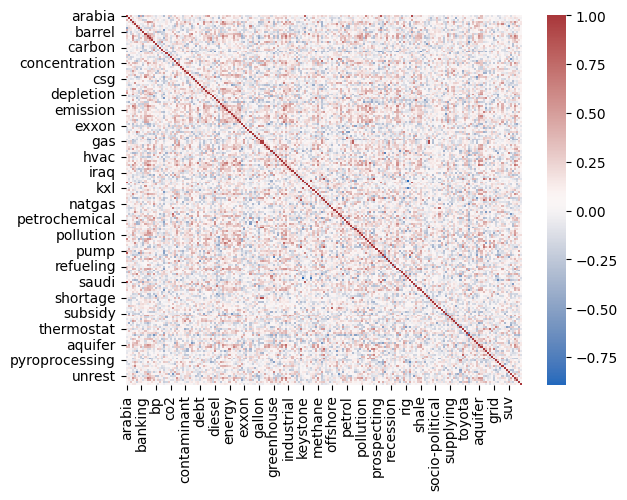

In [ ]:
corr = DFf.corr(method = 'pearson')
sns.heatmap(corr, cmap=sns.color_palette("vlag", as_cmap=True))

In [ ]:
corr.sort_values('Diff', ascending=False)['Diff'][1:]

realpolitik      0.207564
pollution        0.203622
radioactivity    0.202242
import           0.174830
oilfield         0.174045
                   ...   
propane         -0.107660
mining          -0.118681
heating         -0.123593
hvac            -0.127034
riyadh          -0.141807
Name: Diff, Length: 188, dtype: float64

After a small exploration of the correlation, I proceed with the train and test split, with the main difference that I split along a time line; the most recent weeks are what I want to predict, so I use those as "tests."

In [ ]:
finaleval=DFf[-12:]
subset=DFf[:-12]

x_subset = subset.drop(columns=["Diff"]).to_numpy()
y_subset = subset['Diff'].to_numpy()
x_finaleval = finaleval.drop(columns=["Diff"]).to_numpy()
y_finaleval = finaleval[['Diff']].to_numpy()

subset

,arabia,air-conditioning,arab,atmosphere,aviation,atomic,bahrain,banking,barrel,biofuel,...,aerospace,uae,truck,suv,war,unrest,groundwater,gulf,utility,Diff
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-10-21,-0.070350,0.165959,-0.408323,-0.314853,-1.083271,-0.366781,0.499878,0.587424,1.126400,0.226270,...,-0.845790,2.133580,-1.549842,-0.895158,0.686088,-0.421696,0.613868,-0.401372,-0.694890,0.017040
2018-10-28,-0.131793,0.992183,0.052995,0.250077,0.392392,-0.293084,0.390117,1.510660,1.697744,0.763678,...,2.466582,-0.423657,-0.372133,0.005122,0.681242,-1.526335,0.332409,-0.024471,0.171016,0.005704
2018-11-04,-0.008334,-0.182719,-0.038735,0.156185,1.786455,-0.143659,0.711931,0.341763,1.327545,2.180489,...,1.421114,0.222541,1.306740,1.105534,1.261611,-4.143893,1.813575,0.054427,2.007549,0.010659
2018-11-11,-0.192936,-0.416082,-0.223905,1.098507,-0.212763,0.157413,0.439923,1.391321,0.764717,1.569477,...,0.669981,-0.238344,0.311918,0.909245,-0.429977,-0.258794,0.327042,0.207467,0.278819,0.004828
2018-11-18,0.176994,-2.003357,-0.224026,0.344857,-0.472916,-0.146766,0.492355,1.007562,0.105904,0.756730,...,0.585881,2.092351,0.328152,-0.481567,-1.240620,0.068309,0.139372,0.062400,0.711572,0.009515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-18,-0.050365,-0.034081,0.527038,-1.142377,0.617063,-0.213863,0.416604,-0.008677,-0.588172,-0.323973,...,1.336874,0.316314,-1.319625,0.583327,0.118758,0.175372,0.031403,-0.532608,-0.680540,0.020767
2023-06-25,-0.170429,-1.271861,0.619187,-1.046235,0.952096,-0.288077,0.255610,0.131101,1.020975,-1.333978,...,0.231501,-0.788674,0.186280,0.182788,-0.761709,0.336458,-1.168575,-4.566537,0.944740,0.003419
2023-07-02,-0.105596,-0.504963,0.158660,-1.611168,-0.699346,-0.665095,0.148148,-0.515546,0.077819,0.086884,...,0.900784,-0.089718,0.355198,-0.020388,-1.934703,0.088712,-1.256105,-1.351841,-0.022000,-0.035035


This is the Keras NN model. I estimate the best one with trial and error. Since I am outing on a tanh activation, I am also calculating the tanh of the response variable (previous step).

In [ ]:
#initialize
neur = tf.keras.models.Sequential()
#layers
neur.add(tf.keras.layers.Dense(units=1000, activation='tanh'))
neur.add(tf.keras.layers.Dense(units=5000, activation='tanh'))
neur.add(tf.keras.layers.Dense(units=7000, activation='tanh'))

#output layer
neur.add(tf.keras.layers.Dense(units=1))

from keras import backend as K
def custom_metric(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#using mse for regression. Simple and clear
neur.compile(optimizer='Adam', loss='mean_squared_error', metrics=[custom_metric])

#train
neur.fit(x_subset, y_subset, batch_size=220, epochs=2000)



Epoch 1/2000
2/2 [==============================] - 6s 691ms/step - loss: 40.3693 - custom_metric: -961797.6875
Epoch 2/2000
2/2 [==============================] - 3s 667ms/step - loss: 482.1231 - custom_metric: -534075.6875
Epoch 3/2000
2/2 [==============================] - 3s 690ms/step - loss: 84.6802 - custom_metric: -127462.3281
Epoch 4/2000
2/2 [==============================] - 3s 685ms/step - loss: 135.9065 - custom_metric: -178293.9688
Epoch 5/2000
2/2 [==============================] - 4s 1s/step - loss: 80.7488 - custom_metric: -222756.9219
Epoch 6/2000
2/2 [==============================] - 3s 678ms/step - loss: 41.9976 - custom_metric: -55160.1406
Epoch 7/2000
2/2 [==============================] - 3s 739ms/step - loss: 27.9182 - custom_metric: -31683.6543
Epoch 8/2000
2/2 [==============================] - 3s 657ms/step - loss: 9.3396 - custom_metric: -12097.5752
Epoch 9/2000
2/2 [==============================] - 2s 653ms/step - loss: 11.0402 - custom_metric: -46758.984

Not too bad of an R2, not the best, but not bad

In [ ]:
test_out = neur.predict(x_finaleval)
output = finaleval[['Diff']]
output['predicted'] = test_out
output['actual'] = y_finaleval
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("R2: ", r2_score(output['actual'], output['predicted']))
print("MeanSqError: ",np.sqrt(mean_squared_error(output['actual'], output['predicted'])))
print("MeanAbsError: ", mean_absolute_error(output['actual'],output['predicted']))
output = output[['predicted','actual']]
output

1/1 [==============================] - 0s 139ms/step
R2:  0.5636558681556474
MeanSqError:  0.0038486911072155108
MeanAbsError:  0.0030806344814022658


<ipython-input-42-14c14dcd54e4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['predicted'] = test_out
<ipython-input-42-14c14dcd54e4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['actual'] = y_finaleval


,predicted,actual
Timestamp,,
2023-07-23,-0.004525,-0.001893
2023-07-30,0.014654,0.013668
2023-08-06,0.003119,0.006580
2023-08-13,0.002854,0.006927
2023-08-20,0.002569,0.005228
2023-08-27,0.008864,0.010212
2023-09-03,0.002596,0.002310
2023-09-10,-0.008040,-0.001680
2023-09-17,-0.000203,-0.002312


The result shown here is the difference with respect to the next week, so I need to start with the value and difference from the week of July 16, after reversing to a arc tanh

In [ ]:
output = output[['predicted']]
output['predictedArcTanh'] = output['predicted'].apply(lambda x: math.atanh(x))
output

,predicted,predictedArcTanh
Timestamp,,
2023-07-23,-0.004525,-0.004525
2023-07-30,0.014654,0.014655
2023-08-06,0.003119,0.003119
2023-08-13,0.002854,0.002854
2023-08-20,0.002569,0.002569
2023-08-27,0.008864,0.008864
2023-09-03,0.002596,0.002596
2023-09-10,-0.008040,-0.008040
2023-09-17,-0.000203,-0.000203


In [ ]:
ydf[(ydf.index=='2023-07-16') | (ydf.index=='2023-07-23')]

,GASREGW,seasonal_32,seasonal_37,seasonal_52,seasonal_65,seasonal_104,Trend,Resid,Diff
DATE,,,,,,,,,
2023-07-16,3.559,-0.131384,-0.026409,0.341058,-0.141251,-0.819315,4.373422,-0.037122,-0.001443
2023-07-23,3.596,-0.135410,0.032115,0.279535,-0.089731,-0.840544,4.385714,-0.035678,-0.001893


Now, these are predicted values of the residuals.

In [ ]:
output['PredResid'] = np.nan

start = 0
prevval = 0
for index, row in output.iterrows():
 if start == 0:
  prevval = -0.037122 - row['predictedArcTanh']
 else:
  prevval = prevval - row['predictedArcTanh']
 output.at[index, 'PredResid'] = prevval

output = output[['PredResid']]
output

,PredResid
Timestamp,
2023-07-23,-0.032597
2023-07-30,-0.051777
2023-08-06,-0.040241
2023-08-13,-0.039976
2023-08-20,-0.039691
2023-08-27,-0.045986
2023-09-03,-0.039718
2023-09-10,-0.029082
2023-09-17,-0.036919


Now I estimate the trend with a simple linear regression.

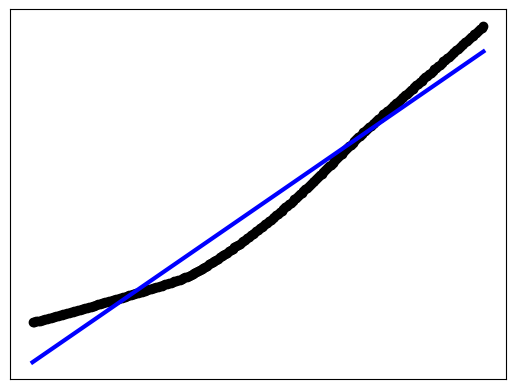

In [ ]:
ydf['rown'] = range(len(ydf))
setreg = ydf[ydf.index <'2023-07-23']
setreg = setreg[['Trend','rown']]
mod = LinearRegression().fit(setreg[['rown']], setreg['Trend'])
setreg['PredTrend'] = mod.predict(setreg[['rown']])
plt.scatter(setreg['rown'], setreg['Trend'], color="black")
plt.plot(setreg['rown'], setreg['PredTrend'], color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
outcome = ydf[ydf.index >='2023-07-23']
outcome = outcome[['GASREGW','rown']]
outcome['PredTrend'] = mod.predict(outcome[['rown']])
outcome

,GASREGW,rown,PredTrend
DATE,,,
2023-07-23,3.596,249,4.187386
2023-07-30,3.757,250,4.197076
2023-08-06,3.828,251,4.206766
2023-08-13,3.850,252,4.216456
2023-08-20,3.868,253,4.226146
2023-08-27,3.813,254,4.235836
2023-09-03,3.807,255,4.245526
2023-09-10,3.822,256,4.255217
2023-09-17,3.878,257,4.264907


For the seasonal values, I fit them to a cosine function by creating a custom numpy function with the model I want to fit and giving it "good" seeds for the parameters (amplitude, frequency, fase angle, and offset). I had to run it several times since the results were very sensible for the seeds. This is predicting seasonal_32.

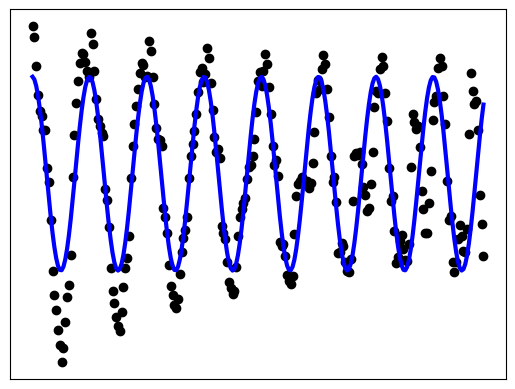

In [ ]:
from scipy import optimize
from sklearn.preprocessing import MinMaxScaler
setreg = ydf[ydf.index <'2023-07-23']
setreg = setreg[['seasonal_32','rown']]
def fit_func(x, a, b, c, d):
    return a*np.cos(b*x+c) + d
params, params_covariance = optimize.curve_fit(fit_func, setreg['rown'], setreg['seasonal_32'], p0=(10,.19,0,0))

setreg['Predseasonal_32'] = setreg['rown'].apply(lambda x: fit_func(x, *params))
plt.scatter(setreg['rown'], setreg['seasonal_32'], color="black")
plt.plot(setreg['rown'], setreg['Predseasonal_32'], color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()


In [ ]:
#assign to outcome
outcome['Predseasonal_32'] = outcome['rown'].apply(lambda x: fit_func(x, *params))
outcome

,GASREGW,rown,PredTrend,Predseasonal_32
DATE,,,,
2023-07-23,3.596,249,4.187386,0.131542
2023-07-30,3.757,250,4.197076,0.145835
2023-08-06,3.828,251,4.206766,0.154386
2023-08-13,3.850,252,4.216456,0.156857
2023-08-20,3.868,253,4.226146,0.153150
2023-08-27,3.813,254,4.235836,0.143411
2023-09-03,3.807,255,4.245526,0.128027
2023-09-10,3.822,256,4.255217,0.107607
2023-09-17,3.878,257,4.264907,0.082960


Predict seasonal_37

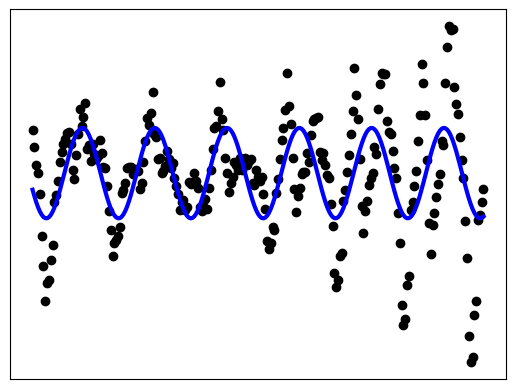

In [ ]:
from scipy import optimize
from sklearn.preprocessing import MinMaxScaler
setreg = ydf[ydf.index <'2023-07-23']
setreg = setreg[['seasonal_37','rown']]
def fit_func(x, a, b, c, d):
    return a*np.cos(b*x+c) + d
params, params_covariance = optimize.curve_fit(fit_func, setreg['rown'], setreg['seasonal_37'], p0=(10,.17,0,0))

setreg['Predseasonal_37'] = setreg['rown'].apply(lambda x: fit_func(x, *params))
plt.scatter(setreg['rown'], setreg['seasonal_37'], color="black")
plt.plot(setreg['rown'], setreg['Predseasonal_37'], color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
#assign to outcome
outcome['Predseasonal_37'] = outcome['rown'].apply(lambda x: fit_func(x, *params))
outcome

,GASREGW,rown,PredTrend,Predseasonal_32,Predseasonal_37
DATE,,,,,
2023-07-23,3.596,249,4.187386,0.131542,-0.062990
2023-07-30,3.757,250,4.197076,0.145835,-0.057636
2023-08-06,3.828,251,4.206766,0.154386,-0.050904
2023-08-13,3.850,252,4.216456,0.156857,-0.042962
2023-08-20,3.868,253,4.226146,0.153150,-0.034008
2023-08-27,3.813,254,4.235836,0.143411,-0.024264
2023-09-03,3.807,255,4.245526,0.128027,-0.013973
2023-09-10,3.822,256,4.255217,0.107607,-0.003392
2023-09-17,3.878,257,4.264907,0.082960,0.007216


Predict seasonal 52

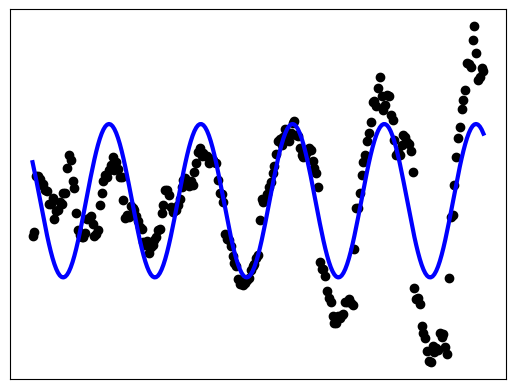

In [ ]:
from scipy import optimize
from sklearn.preprocessing import MinMaxScaler
setreg = ydf[ydf.index <'2023-07-23']
setreg = setreg[['seasonal_52','rown']]
def fit_func(x, a, b, c, d):
    return a*np.cos(b*x+c) + d
params, params_covariance = optimize.curve_fit(fit_func, setreg['rown'], setreg['seasonal_52'], p0=(10,.13,0,0))

setreg['Predseasonal_52'] = setreg['rown'].apply(lambda x: fit_func(x, *params))
plt.scatter(setreg['rown'], setreg['seasonal_52'], color="black")
plt.plot(setreg['rown'], setreg['Predseasonal_52'], color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
#assign to outcome
outcome['Predseasonal_52'] = outcome['rown'].apply(lambda x: fit_func(x, *params))
outcome

,GASREGW,rown,PredTrend,Predseasonal_32,Predseasonal_37,Predseasonal_52
DATE,,,,,,
2023-07-23,3.596,249,4.187386,0.131542,-0.062990,0.167339
2023-07-30,3.757,250,4.197076,0.145835,-0.057636,0.151655
2023-08-06,3.828,251,4.206766,0.154386,-0.050904,0.133757
2023-08-13,3.850,252,4.216456,0.156857,-0.042962,0.113924
2023-08-20,3.868,253,4.226146,0.153150,-0.034008,0.092462
2023-08-27,3.813,254,4.235836,0.143411,-0.024264,0.069703
2023-09-03,3.807,255,4.245526,0.128027,-0.013973,0.046000
2023-09-10,3.822,256,4.255217,0.107607,-0.003392,0.021720
2023-09-17,3.878,257,4.264907,0.082960,0.007216,-0.002762


Predict seasonal 65

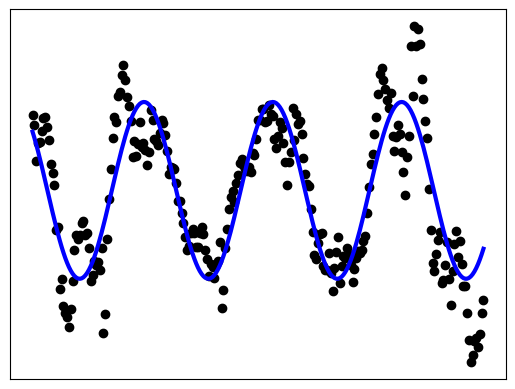

In [ ]:
from scipy import optimize
from sklearn.preprocessing import MinMaxScaler
setreg = ydf[ydf.index <'2023-07-23']
setreg = setreg[['seasonal_65','rown']]
def fit_func(x, a, b, c, d):
    return a*np.cos(b*x+c) + d
params, params_covariance = optimize.curve_fit(fit_func, setreg['rown'], setreg['seasonal_65'], p0=(10,.1,0,0))

setreg['Predseasonal_65'] = setreg['rown'].apply(lambda x: fit_func(x, *params))
plt.scatter(setreg['rown'], setreg['seasonal_65'], color="black")
plt.plot(setreg['rown'], setreg['Predseasonal_65'], color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
#assign to outcome
outcome['Predseasonal_65'] = outcome['rown'].apply(lambda x: fit_func(x, *params))
outcome

,GASREGW,rown,PredTrend,Predseasonal_32,Predseasonal_37,Predseasonal_52,Predseasonal_65
DATE,,,,,,,
2023-07-23,3.596,249,4.187386,0.131542,-0.062990,0.167339,-0.068807
2023-07-30,3.757,250,4.197076,0.145835,-0.057636,0.151655,-0.060588
2023-08-06,3.828,251,4.206766,0.154386,-0.050904,0.133757,-0.051916
2023-08-13,3.850,252,4.216456,0.156857,-0.042962,0.113924,-0.042858
2023-08-20,3.868,253,4.226146,0.153150,-0.034008,0.092462,-0.033486
2023-08-27,3.813,254,4.235836,0.143411,-0.024264,0.069703,-0.023874
2023-09-03,3.807,255,4.245526,0.128027,-0.013973,0.046000,-0.014096
2023-09-10,3.822,256,4.255217,0.107607,-0.003392,0.021720,-0.004231
2023-09-17,3.878,257,4.264907,0.082960,0.007216,-0.002762,0.005644


Predict seasonal 104

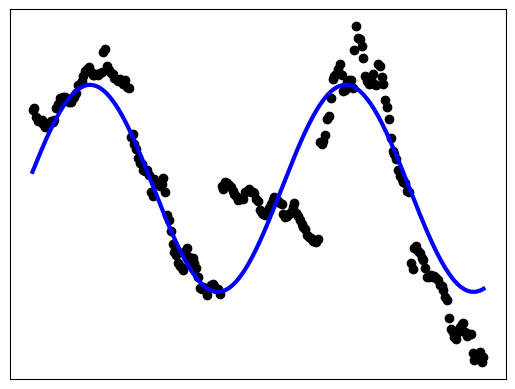

In [ ]:
from scipy import optimize
from sklearn.preprocessing import MinMaxScaler
setreg = ydf[ydf.index <'2023-07-23']
setreg = setreg[['seasonal_104','rown']]
def fit_func(x, a, b, c, d):
    return a*np.cos(b*x+c) + d
params, params_covariance = optimize.curve_fit(fit_func, setreg['rown'], setreg['seasonal_104'], p0=(10,.05,0,0))

setreg['Predseasonal_104'] = setreg['rown'].apply(lambda x: fit_func(x, *params))
plt.scatter(setreg['rown'], setreg['seasonal_104'], color="black")
plt.plot(setreg['rown'], setreg['Predseasonal_104'], color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
#assign to outcome
outcome['Predseasonal_104'] = outcome['rown'].apply(lambda x: fit_func(x, *params))
outcome

,GASREGW,rown,PredTrend,Predseasonal_32,Predseasonal_37,Predseasonal_52,Predseasonal_65,Predseasonal_104
DATE,,,,,,,,
2023-07-23,3.596,249,4.187386,0.131542,-0.062990,0.167339,-0.068807,-0.485424
2023-07-30,3.757,250,4.197076,0.145835,-0.057636,0.151655,-0.060588,-0.478575
2023-08-06,3.828,251,4.206766,0.154386,-0.050904,0.133757,-0.051916,-0.470784
2023-08-13,3.850,252,4.216456,0.156857,-0.042962,0.113924,-0.042858,-0.462066
2023-08-20,3.868,253,4.226146,0.153150,-0.034008,0.092462,-0.033486,-0.452439
2023-08-27,3.813,254,4.235836,0.143411,-0.024264,0.069703,-0.023874,-0.441921
2023-09-03,3.807,255,4.245526,0.128027,-0.013973,0.046000,-0.014096,-0.430534
2023-09-10,3.822,256,4.255217,0.107607,-0.003392,0.021720,-0.004231,-0.418301
2023-09-17,3.878,257,4.264907,0.082960,0.007216,-0.002762,0.005644,-0.405246


Now, I aggregate all the components of the prediction and product a predicted price

In [ ]:
final = pd.merge(outcome,output,left_index=True,right_index=True)
final['GASREGW_prep'] = final['PredTrend'] + final['Predseasonal_32'] + final['Predseasonal_37'] + final['Predseasonal_52'] + final['Predseasonal_65'] + final['Predseasonal_104'] + final['PredResid']
final

,GASREGW,rown,PredTrend,Predseasonal_32,Predseasonal_37,Predseasonal_52,Predseasonal_65,Predseasonal_104,PredResid,GASREGW_prep
2023-07-23,3.596,249,4.187386,0.131542,-0.062990,0.167339,-0.068807,-0.485424,-0.032597,3.836449
2023-07-30,3.757,250,4.197076,0.145835,-0.057636,0.151655,-0.060588,-0.478575,-0.051777,3.845989
2023-08-06,3.828,251,4.206766,0.154386,-0.050904,0.133757,-0.051916,-0.470784,-0.040241,3.881064
2023-08-13,3.850,252,4.216456,0.156857,-0.042962,0.113924,-0.042858,-0.462066,-0.039976,3.899375
2023-08-20,3.868,253,4.226146,0.153150,-0.034008,0.092462,-0.033486,-0.452439,-0.039691,3.912135
2023-08-27,3.813,254,4.235836,0.143411,-0.024264,0.069703,-0.023874,-0.441921,-0.045986,3.912906
2023-09-03,3.807,255,4.245526,0.128027,-0.013973,0.046000,-0.014096,-0.430534,-0.039718,3.921231
2023-09-10,3.822,256,4.255217,0.107607,-0.003392,0.021720,-0.004231,-0.418301,-0.029082,3.929537
2023-09-17,3.878,257,4.264907,0.082960,0.007216,-0.002762,0.005644,-0.405246,-0.036919,3.915800
2023-09-24,3.837,258,4.274597,0.055063,0.017587,-0.027065,0.015453,-0.391395,-0.033615,3.910624


Plot of the predicted and the real prices

(3.0, 4.5)

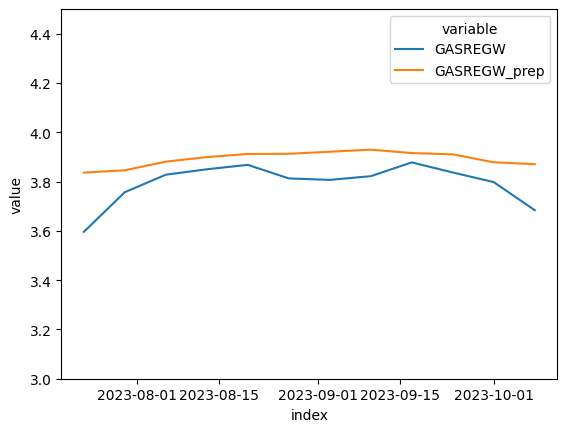

In [ ]:
sns.lineplot(x='index', y='value', hue='variable', data=pd.melt(final[['GASREGW','GASREGW_prep']].reset_index(drop=False), ['index']))
plt.ylim(3,4.5)

Which is very conservative in the price variation, but it is a general trend.